In [1]:
#TODO:
# solver class. for meta-heuristics, use wrapper that 
# - checks constraints feasibility and restarts if violated
# - gradually increases coeffs before constraints

In [2]:
import os, sys
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

import librosa
import scipy.signal

In [3]:
# project_root = "."

# sys.path.append(project_root)

In [4]:
from optim.utils import unpack_bounds

from common.math import logscale

from dsp import load_fir
from dsp import resample, mag2db
from dsp.filters.iir import load_sos, save_sos
from dsp.weighting import weighting_filter

In [5]:
from dsp.filters import parametric_eq, sos_general_parametric

In [6]:
from anc.problem import ProblemFeedback, ProblemFeedforward
from anc.parametrization import ParametrizationEQ, ParametrizationGeneral

In [7]:
from anc.constraints import (
    ConstraintCircle, 
    StabilityConstraintParabola, 
    StabilityConstraintHyperbola,
    ConstraintLowFreq,
    ConstraintHighFreq,
)

In [8]:
fs = 192000

# Load PP & SP responses

In [9]:
dataset_path = "/home/alexey/Documents/python/github/active-noise-control/datasets/PANDAR"


path_pp = f"{dataset_path}/PP/PP_PersonID1_L_normal.txt"
path_sp = f"{dataset_path}/SP/SP_PersonID1_L_normal.txt"
PP = load_fir(path_pp)
SP = load_fir(path_sp)


PP = 0
file_list = glob.glob(f"{dataset_path}/PP/PP_*")
for path in file_list:
    PP += load_fir(path)
PP /= len(file_list)

SP = 0
file_list = glob.glob(f"{dataset_path}/SP/SP_*")
for path in file_list:
    SP += load_fir(path)
SP /= len(file_list)


PP = resample(PP, fs=48000, fs_new=fs)
SP = resample(SP, fs=48000, fs_new=fs)

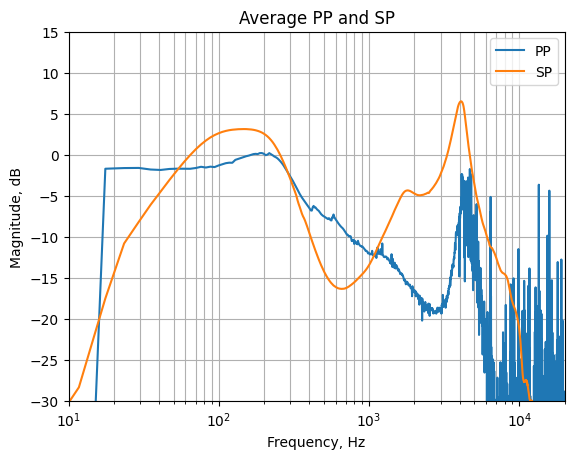

In [10]:
w, h_pp_avg = scipy.signal.freqz(PP, 1, worN=16384, fs=fs)
w, h_sp_avg = scipy.signal.freqz(SP, 1, worN=16384, fs=fs)

plt.semilogx(w, mag2db(np.abs(h_pp_avg)), label="PP");
plt.semilogx(w, mag2db(np.abs(h_sp_avg)), label="SP");

plt.grid(which="both");
plt.xlim(10, 20000);
plt.ylim(-30, 15);

plt.xlabel("Frequency, Hz");
plt.ylabel("Magnitude, dB");

plt.legend();
plt.title("Average PP and SP");

In [11]:
seed = 42

np.random.seed(seed)

In [12]:
from anc.configs import config_v0 as cfg

# n_fft = cfg.n_fft
# log = cfg.log
# freq = cfg.freq
# weighting = cfg.weighting


# if cfg.log:
#     from common.math import logscale
#     freqs = logscale(0, 1, cfg.n_fft)
# else:
#     freqs = np.linspace(0, 1, cfg.n_fft)
    
# from scipy.stats import beta

# a, b = 1, 10
# cfg.weighting = beta(a, b).pdf(freqs) + 1e-6
# cfg.weighting /= cfg.weighting.max()

Use [frequency weighting](https://en.wikipedia.org/wiki/Weighting) curves to define the weighted sensitivity as an objective function for controller design

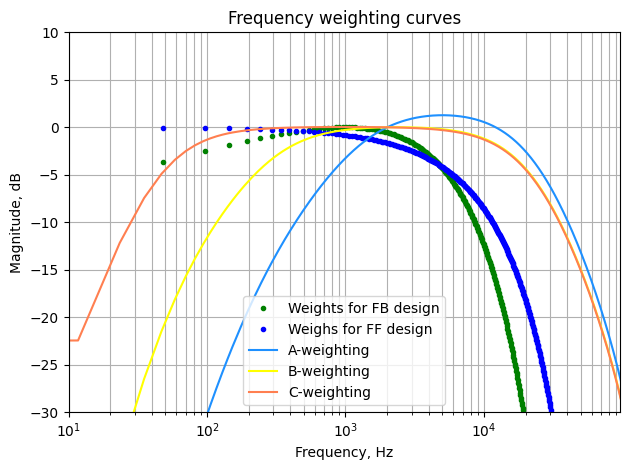

In [13]:
plt.semilogx(cfg.freqs * fs, mag2db(cfg.weighting_feedback), ".g", label="Weights for FB design");
plt.semilogx(cfg.freqs * fs, mag2db(cfg.weighting_feedforward), ".b", label="Weighs for FF design");

sos = weighting_filter(fs, curve="A")
w, h = scipy.signal.sosfreqz(sos, worN=16384, fs=2)
plt.semilogx(w * fs, mag2db(np.abs(h)), color="dodgerblue", label="A-weighting");

sos = weighting_filter(fs, curve="B")
w, h = scipy.signal.sosfreqz(sos, worN=16384, fs=2)
plt.semilogx(w * fs, mag2db(np.abs(h)), color="yellow", label="B-weighting");

sos = weighting_filter(fs, curve="C")
w, h = scipy.signal.sosfreqz(sos, worN=16384, fs=2)
plt.semilogx(w * fs, mag2db(np.abs(h)), color="coral", label="C-weighting");

plt.grid(which="both");
plt.xlim(10, fs/2);
plt.ylim(-30, 10);

plt.xlabel("Frequency, Hz");
plt.ylabel("Magnitude, dB");

plt.legend();
plt.title("Frequency weighting curves");

plt.tight_layout();
plt.savefig(f"weighting_curves.png", dpi=300); # move to /images

# Feedback controller design

In [14]:
problem = ProblemFeedback(fs, n_fft=cfg.n_fft, logspace=cfg.log)
problem.init(SP, cfg.weighting_feedback)


n_sections = 6

ftypes = ["ls", "hs", "pk", "pk", "pk", "pk"]
assert len(ftypes) == n_sections

parametrization = ParametrizationEQ(n_sections, ftypes, fs)
# parametrization = ParametrizationGeneral(n_sections, fs)

problem.set_parametrization(parametrization)

problem.add_constraints(cfg)

bounds = parametrization.bounds()
problem.add_bounds(bounds)

constraints = parametrization.constraints()
assert constraints is None or len(constraints) == 0

Define weights for each constraint to convert the original constrained problem to an unconstrained problem

In [15]:
weights = {
    "circle": 0.0001,
    "parabola": 0.001,
    "lowfreq": 0.0001,
    "highfreq": 0.0001,
}

problem_unc = problem.to_unconstrained(weights)

In [16]:
from optim.solver.heuristic import SolverMetaHeuristic

In [17]:
epoch = 200
pop_size = 500

solver = SolverMetaHeuristic(problem_unc)
solver.prepare("gwo", epoch, pop_size)
sol = solver.solve(seed=seed)

In [18]:
sos = parametrization.decode(sol)

freq, FB = problem.sosfreqz(sos)

save_sos("results/fb.csv", sos)

In [19]:
loss = problem.objective(sos)
print("Loss:", loss)

print("Constraints:")        
problem.violation(sos)

Loss: 0.04623271421067504
Constraints:
[OK]:	-0.34021274671108315 	< 0 (circle)
[OK]:	-0.2990347529050472 	< 0 (parabola)
[OK]:	-3.9948263156073116 	< 0 (lowfreq)
[OK]:	-3.6207981256729815 	< 0 (highfreq)


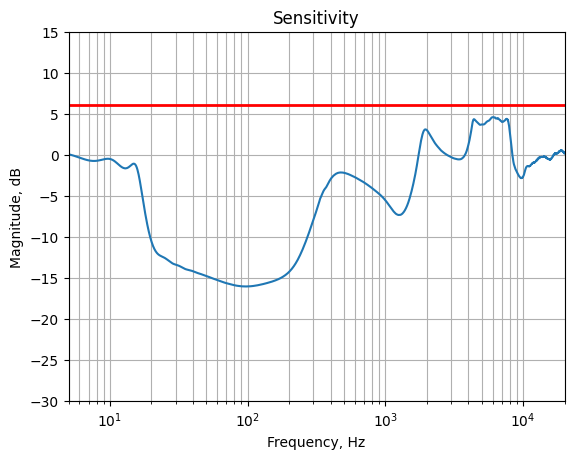

In [20]:
worN = logscale(0, 1, 32768) * 20000

w, h_fb = scipy.signal.sosfreqz(sos, worN=worN, fs=fs)
w, h_sp = scipy.signal.freqz(SP, 1, worN=worN, fs=fs)
S_fb = 1 / (1 + h_fb * h_sp)

# w = np.linspace(0, fs//2, len(S_fb))
plt.semilogx(w, mag2db(np.abs(S_fb)));

x_min, x_max = 5, 20000
y_min, y_max = -30, 15

plt.plot([x_min, x_max], [cfg.gain_max, cfg.gain_max], "r", linewidth=2)

plt.grid(which="both");
plt.xlim(x_min, x_max);
plt.ylim(y_min, y_max);

plt.xlabel("Frequency, Hz");
plt.ylabel("Magnitude, dB");

plt.title("Sensitivity");

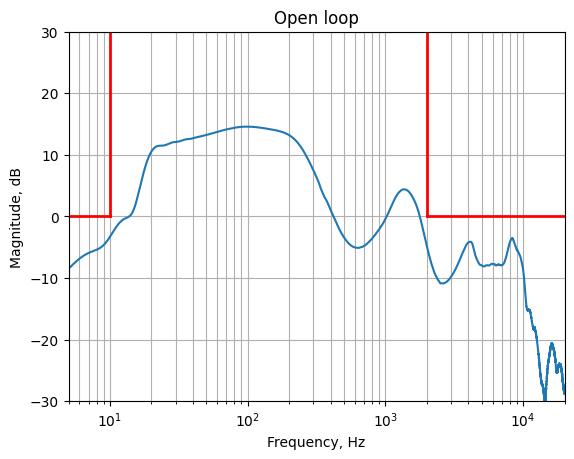

In [21]:
H = h_fb * h_sp

plt.semilogx(w, mag2db(np.abs(H)));

x_min, x_max = 5, 20000
y_min, y_max = -30, 30

plt.plot([cfg.freq_low, cfg.freq_low], [cfg.gain_open_max, y_max], "r", linewidth=2)   
plt.plot([0, cfg.freq_low], [cfg.gain_open_max, cfg.gain_open_max], "r", linewidth=2)

plt.plot([cfg.freq_high, cfg.freq_high], [cfg.gain_open_max, y_max], "r", linewidth=2)
plt.plot([cfg.freq_high, x_max], [cfg.gain_open_max, cfg.gain_open_max], "r", linewidth=2)

plt.grid(which="both");
plt.xlim(x_min, x_max);
plt.ylim(y_min, y_max);

plt.xlabel("Frequency, Hz");
plt.ylabel("Magnitude, dB");

plt.title("Open loop");

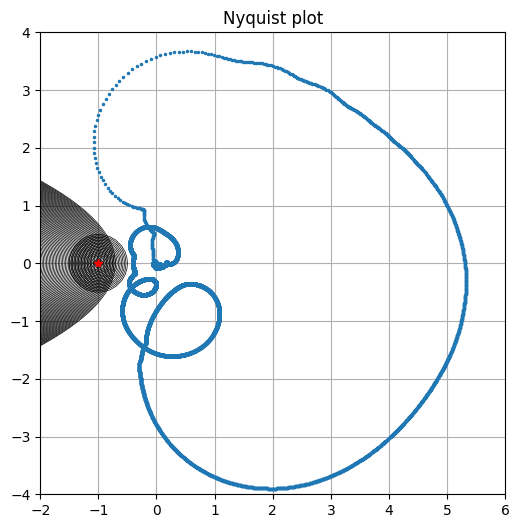

In [22]:
plt.figure(figsize=(6, 6));

#-----------------
constraint_circle = ConstraintCircle(cfg.gain_max)

constraint_parabola = StabilityConstraintParabola(cfg.gain_margin, cfg.phase_margin)
# constraint_hyperbola = StabilityConstraintHyperbola(cfg.gain_margin)

x_range = (-2, 6)
y_range = (-5, 5)

X = np.arange(*x_range, step=0.1)
Y = np.arange(*y_range, step=0.1)

X, Y = np.meshgrid(X, Y)
Z = X + 1j * Y

levels = np.linspace(0, 5, 200)
plt.contour(X, Y, constraint_parabola(Z), levels=levels, colors=["black"], linewidths=0.5);
plt.contour(X, Y, constraint_circle(Z), levels=levels, colors=["black"], linewidths=0.5);

#-----------------
plt.plot(H.real, H.imag, ".", markersize=3);
plt.plot(-1, 0, "r*");


plt.xlim(-2, 6);
plt.ylim(-4, 4);

plt.grid(which="both");
plt.title("Nyquist plot");

plt.savefig(f"nyquist_plot.png", dpi=300); # move to /images

### Fine-tuning using gradient-based solver

In [23]:
from optim.solver.gradient import SolverGradient

In [24]:
x_init = sol

print(x_init)

[ 1.79952432e+03  5.84908387e+03  4.10184709e+03  2.98110744e+00
  7.13784037e+03  2.97997377e+00  2.00033906e+00  2.46378085e+00
  3.89510498e+00  1.00004221e-01  3.22607819e+00  1.00210226e-01
  1.00000000e+01  9.99508214e+00 -2.63030226e+00  1.00000000e+01
 -7.03980792e+00  1.00000000e+01]


In [25]:
slack_l, slack_u = problem.bounds.residual(x_init)
np.all(np.r_[slack_l, slack_u] > 0) # assert

False

In [26]:
# solver = SolverGradient(problem)
# solver.prepare(maxiter=100)
# sol = solver.solve(x_init)

In [27]:
# print(sol)

# Feedforward controller design

In [28]:
# Feedforward
problem_ff = ProblemFeedforward(fs, n_fft=cfg.n_fft, logspace=cfg.log)

# problem_ff.init(PP, SP, FB=None, weighting=cfg.weighting_feedforward) # w/o  FB
problem_ff.init(PP, SP, FB, weighting=cfg.weighting_feedforward) # w/ FB

problem_ff = problem_ff.to_unconstrained({})

In [29]:
ftypes = ["ls", "hs", "pk", "pk", "pk", "pk"]
n_sections = len(ftypes)
parametrization = ParametrizationEQ(n_sections, ftypes, fs)

problem_ff.set_parametrization(parametrization)

bounds = parametrization.bounds()

from optim.utils import unpack_bounds
problem_ff.add_bounds(bounds)

constraints = parametrization.constraints()
assert constraints is None or len(constraints) == 0

In [30]:
epoch = 100
pop_size = 500

solver_ff = SolverMetaHeuristic(problem_ff)
solver_ff.prepare("gwo", epoch, pop_size)
sol_ff = solver_ff.solve(seed=seed)

In [31]:
sos_ff = parametrization.decode(sol_ff)

save_sos("results/ff.csv", sos_ff)

In [32]:
# w, h_pp = scipy.signal.freqz(PP, 1, worN=16384, fs=fs)
# w, h_sp = scipy.signal.freqz(SP, 1, worN=16384, fs=fs)
# w, h_ff = scipy.signal.sosfreqz(sos, worN=16384, fs=fs)

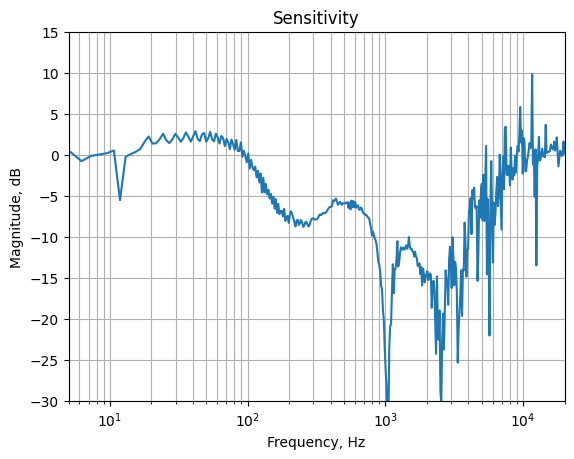

In [33]:
w0, S_ff = problem_ff.sensitivity(sos_ff)
plt.semilogx(w0, mag2db(np.abs(S_ff)));

# plt.semilogx(w, mag2db(np.abs((h_pp - h_ff * h_sp) / h_pp)));
# plt.semilogx(w, mag2db(np.abs(- h_pp / h_sp)));
# plt.semilogx(w, mag2db(np.abs(h_ff)));

plt.grid(which="both");
plt.xlim(5, 20000);
plt.ylim(-30, 15);

plt.xlabel("Frequency, Hz");
plt.ylabel("Magnitude, dB");

plt.title("Sensitivity");